In [164]:
import pandas as pd
import numpy as np
import heapq
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
from metric import *
tqdm.pandas()

In [2]:
df = pd.read_parquet("../data/train.parquet")
train = df.query("completed_at < '2021-09-01'")
test = df.query("completed_at > '2021-09-01' & completed_at < '2021-10-01'")
del df

In [204]:
train.head()

id   order_id           retailer_id              city_id  \
0  3197105899698320871  107957174  11560278657910940989  8747619198118818142   
1  3197105899698320871  107957174  11560278657910940989  8747619198118818142   
2  3197105899698320871  107957174  11560278657910940989  8747619198118818142   
3  3197105899698320871  107957174  11560278657910940989  8747619198118818142   
4  3197105899698320871  107957174  11560278657910940989  8747619198118818142   

              store_id  product_price  product_quantity  product_discount  \
0  2428082163982315652     899.000000                 1         394.01001   
1  2428082163982315652     104.010002                 1           0.00000   
2  2428082163982315652      46.790001                 1           0.00000   
3  2428082163982315652     159.000000                 1          82.00000   
4  2428082163982315652     159.000000                 1          70.00000   

         completed_at  cluster_id product_price_bins  spent_money  \
0 2021-06-01 10:34:36         152                 10   504.989990   
1 2021-06-01 10:34:36        3952                  4   104.010002   
2 2021-06-01 10:34:36        7752                  2    46.790001   
3 2021-06-01 10:34:36        7515                  5    77.000000   
4 2021-06-01 10:34:36         789                  5    89.000000   

  spent_money_bins  
0               71  
1               24  
2               13  
3               19  
4               21

In [198]:
mean_prices = train.groupby('id')['product_price'].mean().reset_index()['product_price']
mean_prices.max()

44999.0

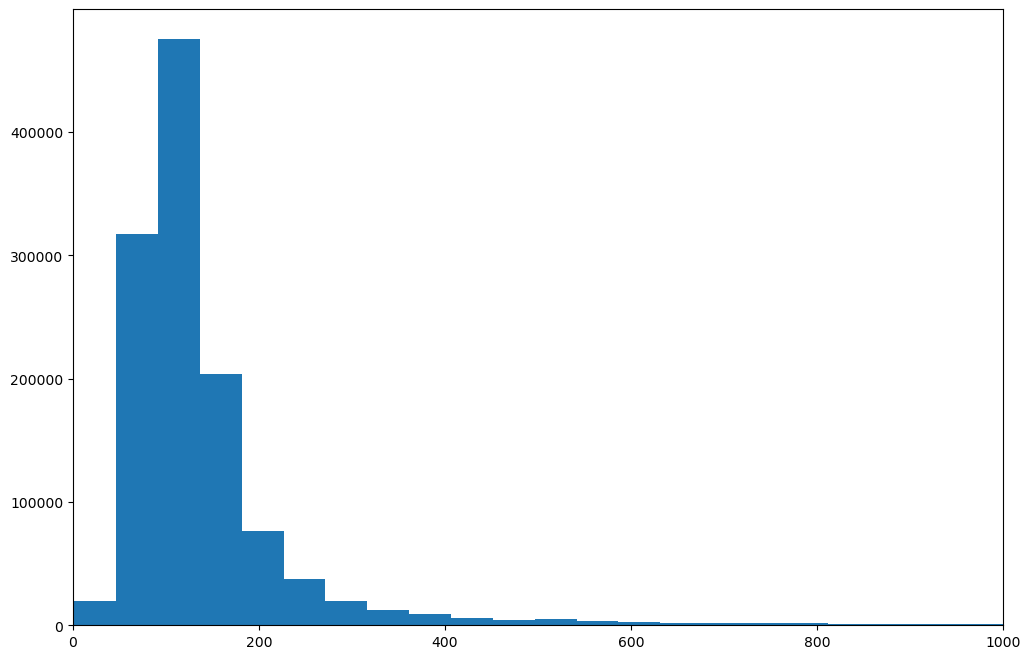

In [201]:
plt.figure(figsize=(12, 8))
plt.hist(mean_prices, bins=1000)
plt.xlim(0, 1000)
plt.show()

In [205]:
# prices
bins_prices = [0, 25, 50, 100, 150, 200, 250, 300, 400, 600, 1000, 10000, 50000]
labels_prices = list(range(1, 13))
train['product_price_bins'] = pd.cut(train['product_price'], bins=bins_prices, labels=labels_prices)

In [206]:
# spent money
train['spent_money'] = train.product_price * train.product_quantity - train.product_discount

bins_spent = [-10000, -1000, -100]
bins_spent.extend(list(range(0, 255, 5))) 
bins_spent.extend(list(range(255, 600, 15)))
bins_spent.extend(list(range(615, 1000, 50)))
bins_spent.extend(list(range(1050, 10000, 1000)))
bins_spent.extend(list(range(10000, 130000, 10000)))
labels_spent = list(range(1, 106))
train['spent_money_bins'] = pd.cut(train['spent_money'], bins=bins_spent, labels=labels_spent)

In [207]:
cities_id = train.groupby("id")["city_id"].first()
prices_id = train.groupby("id")["product_price_bins"].first()
spent_money_id = train.groupby("id")["spent_money_bins"].first()
retailers_id = train.groupby("id")["retailer_id"].first()

In [208]:
def topKFrequent(nums, k): 
        count = Counter(nums)   
        return heapq.nlargest(k, count.keys(), key=count.get) 

def count_values(nums): 
        count = Counter(nums)   
        return [count]
        
def get_top_k(x, k):
    return topKFrequent(x.values,k)   

# def blend_reccomendation(a, b):
#     a = a[0]
#     b = b[0]
#     return heapq.nlargest(16, b.keys(), key=b.get) + heapq.nlargest(4, a.keys(), key=a.get)

def blend_reccomendation(a, b, c):
    a = a[0]
    b = b[0]
    c = c[0]
    return heapq.nlargest(4, a.keys(), key=a.get) + heapq.nlargest(13, b.keys(), key=b.get) + heapq.nlargest(3, c.keys(), key=c.get)   

In [209]:
recommended_city_id = train.groupby("city_id")["cluster_id"].apply(count_values).rename("target_city")
recommended_by_ids = train.groupby("id")["cluster_id"].apply(count_values).rename("target_cluster")
recommended_by_spent_money = train.groupby("spent_money_bins")["cluster_id"].apply(count_values).rename("target_spent_money")
recommended_retailer_id = train.groupby("retailer_id")["cluster_id"].apply(count_values).rename("target_retailer")
recommended_by_prices = train.groupby("product_price_bins")["cluster_id"].apply(count_values).rename("target_price")

In [220]:
one_user = recommended_by_ids.to_frame().join(cities_id).reset_index().merge(recommended_city_id, on="city_id")
one_user = one_user.join(spent_money_id, on='id').merge(recommended_by_spent_money, on="spent_money_bins")
one_user = one_user.join(prices_id, on='id').merge(recommended_by_prices, on="product_price_bins")
one_user = one_user.join(retailers_id, on='id').reset_index().merge(recommended_retailer_id, on="retailer_id")
one_user

index                    id  \
0              0        24382228104511   
1              1     62549886794530032   
2             10    469214781197120469   
3             16    772829345382455999   
4             26   1438532202135094250   
...          ...                   ...   
1219202  1217348  16695847527889210765   
1219203  1217931    934465993301083869   
1219204  1218448   6879756583798359444   
1219205  1218653   7664897973322055633   
1219206  1218986  12437887380057637819   

                                            target_cluster  \
0        [{4938: 4, 2235: 4, 6792: 2, 2226: 5, 1666: 4,...   
1        [{6189: 1, 6112: 1, 2294: 1, 4502: 1, 5998: 1,...   
2        [{3102: 1, 3717: 1, 789: 1, 2111: 1, 1867: 1, ...   
3        [{21: 7, 5139: 4, 1006: 10, 2962: 2, 6368: 1, ...   
4        [{6189: 1, 129: 2, 1694: 1, 7300: 1, 1574: 2, ...   
...                                                    ...   
1219202                      [{1183: 1, 6950: 1, 6626: 1}]   
1219203  [{1615: 1, 3021: 1, 840: 1, 2001: 1, 397: 1, 4...   
1219204                                        [{4833: 1}]   
1219205                                        [{1887: 1}]   
1219206                                        [{5779: 1}]   

                      city_id  \
0        15524014261462246325   
1        15524014261462246325   
2        15524014261462246325   
3        15524014261462246325   
4        15524014261462246325   
...                       ...   
1219202  15524014261462246325   
1219203  15524014261462246325   
1219204  15524014261462246325   
1219205  15524014261462246325   
1219206  15524014261462246325   

                                               target_city spent_money_bins  \
0        [{937: 112981, 2351: 48732, 211: 6877, 4096: 6...               40   
1        [{937: 112981, 2351: 48732, 211: 6877, 4096: 6...               40   
2        [{937: 112981, 2351: 48732, 211: 6877, 4096: 6...               40   
3        [{937: 112981, 2351: 48732, 211: 6877, 4096: 6...               40   
4        [{937: 112981, 2351: 48732, 211: 6877, 4096: 6...               40   
...                                                    ...              ...   
1219202  [{937: 112981, 2351: 48732, 211: 6877, 4096: 6...               89   
1219203  [{937: 112981, 2351: 48732, 211: 6877, 4096: 6...               90   
1219204  [{937: 112981, 2351: 48732, 211: 6877, 4096: 6...               94   
1219205  [{937: 112981, 2351: 48732, 211: 6877, 4096: 6...               92   
1219206  [{937: 112981, 2351: 48732, 211: 6877, 4096: 6...               95   

                                        target_spent_money product_price_bins  \
0        [{1445: 3029, 345: 4315, 3716: 32, 7052: 152, ...                  2   
1        [{1445: 3029, 345: 4315, 3716: 32, 7052: 152, ...                  2   
2        [{1445: 3029, 345: 4315, 3716: 32, 7052: 152, ...                  2   
3        [{1445: 3029, 345: 4315, 3716: 32, 7052: 152, ...                  2   
4        [{1445: 3029, 345: 4315, 3716: 32, 7052: 152, ...                  2   
...                                                    ...                ...   
1219202  [{2288: 48, 3612: 12, 292: 53, 4938: 60, 1136:...                 11   
1219203  [{6102: 2, 894: 1, 3408: 1, 5058: 1, 4792: 1, ...                 11   
1219204  [{7125: 1, 1023: 14, 3021: 3, 988: 19, 1890: 6...                 11   
1219205  [{4254: 3, 6831: 1, 2924: 2, 5614: 7, 5807: 5,...                 11   
1219206  [{4134: 1, 595: 1, 2723: 6, 5010: 1, 4788: 1, ...                 12   

                                              target_price  \
0        [{7752: 10353, 937: 105830, 2524: 29707, 2147:...   
1        [{7752: 10353, 937: 105830, 2524: 29707, 2147:...   
2        [{7752: 10353, 937: 105830, 2524: 29707, 2147:...   
3        [{7752: 10353, 937: 105830, 2524: 29707, 2147:...   
4        [{7752: 10353, 937: 105830, 2524: 29707, 2147:...   
...                                                    ...   
1219202 

In [221]:
one_user["result"] = one_user.apply(lambda x: blend_reccomendation(x["target_cluster"], x["target_city"], x["target_spent_money"]), axis=1)

In [232]:
one_user[["id", "result"]].to_parquet("../data/one_user_result.parquet")

In [222]:
submission = one_user[["id", "result"]]
submission["result"] = submission["result"].apply(set).apply(lambda x: ";".join(str(i) for i in x))

C:\Users\Arcry\anaconda3\envs\envwork\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [223]:
true_values = test.groupby("id")["cluster_id"].apply(lambda x: get_top_k(x, 20)).rename("target")
true_values = true_values.apply(lambda x: ";".join(str(i) for i in x)).reset_index()
    
distinct_values = set(submission["id"].unique()) ^ set(true_values["id"].unique())
    
submission = submission[~submission.id.isin(distinct_values)]
true_values = true_values[~true_values.id.isin(distinct_values)]

In [224]:
submission = submission[~submission.id.isin(distinct_values)]
true_values = true_values[~true_values.id.isin(distinct_values)]
    
history = get_history(train)
cluster_weights = get_cluster_weights(train)

In [225]:
competition_metric_low_memory(submission.rename({"result": "target"}, axis=1), true_values, cluster_weights, history, 20)

0.018977128730308514